This script compares the impact of increasing the number of edges in random small world graphs. Since the theoretical motivation behind our approach relies on graphins, we expect that increasing the density of edges will hinder the performance. In addition, our proposed method is compared with other baselines.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
def run_exp(id, models, KK, iters):
    L_hat = np.zeros((N, N, len(models), len(KK)))
    lamd_hat = np.zeros((N, len(models), len(KK)))
    Ls = np.zeros((N, N, len(KK)))
    lamds = np.zeros((N, len(KK)))
    cs_err = np.zeros((len(models), len(KK)))
    for i, k in enumerate(KK):
        # Create graphs
        A0 = nx.to_numpy_array(nx.watts_strogatz_graph(N0, k, p, seed=SEED))
        L0 = np.diag(np.sum(A0, 0)) - A0
        lambdas0, _ = np.linalg.eigh(L0)

        A = nx.to_numpy_array(nx.watts_strogatz_graph(N, k, p))
        Ls[:,:,i] = np.diag(np.sum(A, 0)) - A
        lamds[:,i], _ = np.linalg.eigh(Ls[:,:,i])            

        # Create signals
        X = utils.create_signals(Ls[:,:,i], M)
        C_hat = X@X.T/M

        # Estimate graph
        for j, model in enumerate(models):
            lamds_ref = lambdas0
            if model['name'] in ['MGL-Tr', 'MGL-Sq', 'MGL-Heat', 'MGL-Poly']:
                if 'true_ref' in model.keys() and model['true_ref']:
                    lamds_ref = lamds[:,i]
                model['cs'], cs_err[j,i] = utils.compute_cs(model['gs'], lamds_ref, lamds[:,i])           
            
            elif model['name'] == 'MGL-Tr=1':
                model['cs'] = 1

            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters)
            t = time.time() - t
            print('Graph-{}, k-{}: Model: {} - cs: {:.4f} - Time(sec): {:.3}'.
                  format(id, k, model['name'], cs_err[j,i], t))
    return L_hat, lamd_hat, Ls, lamds, cs_err


def est_errs1(Ls, lamds, L_hat, lams_hat, sq_err=True):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            L = Ls[:,:,i,k]
            lamd = lamds[:,i,k]
            norm_L = np.linalg.norm(L, 'fro')
            norm_lam = np.linalg.norm(lamd, 2)

            for j in range(L_hat.shape[-3]):
                err_L[j,i,k] = np.linalg.norm(L-L_hat[:,:,j,i,k], 'fro')/norm_L
                err_lamb[j,i,k] = np.linalg.norm(lamd-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def est_errs2(Ls, lamds, L_hat, lams_hat, sq_err=True):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            L = Ls[:,:,i,k]
            lamd = lamds[:,i,k]
            norm_L = np.linalg.norm(L, 'fro')
            norm_lam = np.linalg.norm(lamd, 2)

            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(KK, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(KK, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(KK, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Mean node degree')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([KK[0], KK[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()

## Constants

In [3]:
# Graph params
p = .1
N0 = 150
N = 100
M = 1000

n_graphs = 50
KK = np.arange(4, 21, 2)
iters = 200

GS = [
    lambda a, b : cp.sum(a)/b,    # delta: 4e-2
    lambda a, b : cp.sum(a**2)/b,  # delta: .7
    lambda a, b : cp.sum(cp.exp(-a))/b,    # delta: 3e-3
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

deltas = [1e-4, .3, .005, .1]

models = [
    # Baselines
    {'name': 'Pinv', 'fmt': 'v-'},
    {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^-'},
    {'name': 'MGL-Tr=1', 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': 1.3, 'c1': .01, 'c2': 50, 'conn_comp': 1}},

    # Our algorithms
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 0, 'deltas': deltas[0]}},
    # {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
    #  'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 2500, 'deltas': deltas[1]}},
    {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 1, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.2, 'gamma': 5000, 'deltas': deltas[3]}},
]

## Estimate graphs

In [4]:
total_t = time.time()
Ls = np.zeros((N, N, len(KK), n_graphs))
lamds = np.zeros((N, len(KK), n_graphs))
Ls_hat = np.zeros((N, N, len(models), len(KK), n_graphs))
lamds_hat = np.zeros((N, len(models), len(KK), n_graphs))
cs_err = np.zeros((len(models), len(KK), n_graphs))
print('N_CPUS:', N_CPUS)

pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models, KK, iters) for i in range(n_graphs))

for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i], Ls[:,:,:,i], \
        lamds[:,:,i], cs_err[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
WARNING!! YOU AER USING DELTAS BASED ON CS!!
----- 33.827052128314975  mins -----


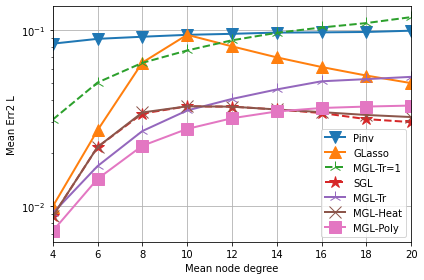

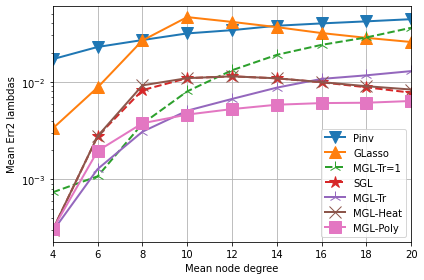

In [5]:
err_L, err_lamb = est_errs2(Ls, lamds, Ls_hat, lamds_hat)
# mean_cs_err = np.abs(np.mean(cs_err, 2))
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
# plot_err(KK, models, mean_cs_err, 'Mean cs err', semlogy=True)
plot_err(KK, models, mean_err_L, 'Mean Err2 L')
plot_err(KK, models, mean_err_lam, 'Mean Err2 lambdas')

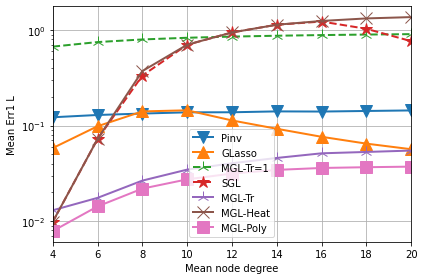

In [6]:
err_L, _ = est_errs1(Ls, lamds, Ls_hat, lamds_hat)
mean_err_L = np.median(err_L, 2)
plot_err(KK, models, mean_err_L, 'Mean Err1 L')

In [ ]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]
# data = {
#     'Ls': Ls,
#     'lamds': lamds,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'cs_err': cs_err,
#     'KK': KK,
#     'iters' : iters,
#     'models': models_aux,
#     'M': M,
# }
# file = 'density_{}graphs_{}iters_{}M'.format(n_graphs, iters, M)
# np.save('results/graph_density/' + file, data)

## Using true graphs as ref for baseline

In [ ]:
deltas = [1e-4, .3, .005, .1]

# regs M=1000
models = [
    # Baselines
    {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^-'},
    {'name': 'MGL-Tr=1', 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 0, 'deltas': deltas[0]}},

    # Our algorithms
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 0, 'deltas': deltas[0]}},
    # {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
    #  'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 2500, 'deltas': deltas[1]}},
    {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 1, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.2, 'gamma': 5000, 'deltas': deltas[3]}},

    {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'true_ref': True, 'fmt': 'x-',
     'regs': {'alpha': 0, 'beta': 1.3, 'gamma': 1, 'deltas': 1e-3}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'true_ref': True, 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.2, 'gamma': 5000, 'deltas': 1e-3}},
]

## Estimate graphs

In [ ]:
total_t = time.time()
Ls2 = np.zeros((N, N, len(KK), n_graphs))
lamds2 = np.zeros((N, len(KK), n_graphs))
Ls_hat2= np.zeros((N, N, len(models), len(KK), n_graphs))
lamds_hat2 = np.zeros((N, len(models), len(KK), n_graphs))
cs_err2 = np.zeros((len(models), len(KK), n_graphs))
print('N_CPUS:', N_CPUS)

pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models, KK, iters) for i in range(n_graphs))

for i, resp in enumerate(resps):
    Ls_hat2[:,:,:,:,i], lamds_hat2[:,:,:,i], Ls2[:,:,:,i], \
        lamds2[:,:,i], cs_err2[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
WARNING!! YOU AER USING DELTAS BASED ON CS!!
----- 33.827052128314975  mins -----


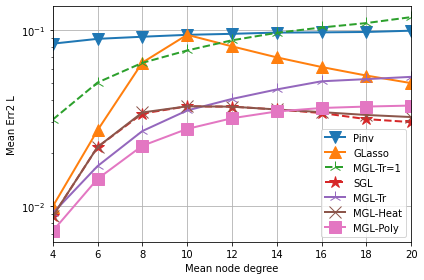

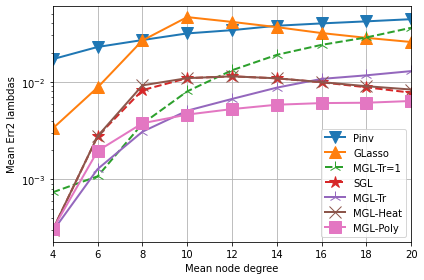

In [ ]:
err_L, err_lamb = est_errs2(Ls2, lamds2, Ls_hat2, lamds_hat2)
# mean_cs_err = np.abs(np.mean(cs_err, 2))
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
# plot_err(KK, models, mean_cs_err, 'Mean cs err', semlogy=True)
plot_err(KK, models, mean_err_L, 'Mean Err2 L')
plot_err(KK, models, mean_err_lam, 'Mean Err2 lambdas')

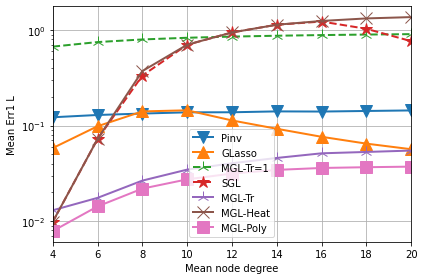

In [ ]:
err_L, _ = est_errs1(Ls2, lamds2, Ls_hat2, lamds_hat2)
mean_err_L = np.median(err_L, 2)
plot_err(KK, models, mean_err_L, 'Mean Err1 L')

In [ ]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]
# data = {
#     'Ls': Ls,
#     'lamds': lamds,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'cs_err': cs_err,
#     'KK': KK,
#     'iters' : iters,
#     'models': models_aux,
#     'M': M,
# }
# file = 'density_{}graphs_{}iters_{}M'.format(n_graphs, iters, M)
# np.save('results/graph_density/' + file, data)

In [8]:
# # Load data
# %matplotlib qt
# file = 'results/graph_density/density_50graphs_200iters_1000M.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# Ls = data['Ls']
# lamds = data['lamds']
# Ls_hat = data['Ls_hat']
# lamds_hat = data['lamds_hat']
# KK = data['KK']
# iters = data['iters']
# models = data['models']